# Cepheid Variable Analysis
### Sean Stroud

In [3]:
#Python package imports
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr
from scipy.optimize import curve_fit
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [9]:
def LightCurver(ceph_list, lc_file):
    """
    
    Inputs: 
    'ceph_list', a list Gaia source IDs for the desired Cepheids to analyze (String).
    'lc_file', a downloaded text file of Gaia DR2 light curve data (String).
    The pipeline will search if a given Cepheid in 'ceph_list' exists in 'lc_file'. 
    
    Outputs: 
    Light curve figure in terms of flux.
    Light curve figure in terms of magnitude.
    """
    
    ###Retrieving list of desired Cepheids to analyze
    ceph_sources = np.loadtxt(ceph_list, dtype=np.int64)
    
    ###Retrieving properties of cataloged Cepheids from the public Gaia table "vari_cepheid".
    job = Gaia.launch_job_async("select top 10000 * from gaiadr2.vari_cepheid order by source_id")
    r = job.get_results()
    
    ###Retreving and sorting light curve properties from downloaded Gaia files
    lcs = np.loadtxt(lc_file,skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
    source_id = np.loadtxt(lc_file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
    band = np.loadtxt(lc_file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
    time = lcs[:,0]
    mag = lcs[:,1]
    flux = lcs[:,2]
    flux_error = lcs[:,3] 

    ###Important constants
    zp = 25.6883657251 #Gaia DR2 zero point
    
    for i in range(0, len(ceph_sources)):
        ###If we wish to only look at one particular Cepheid, we may uncomment the following two lines.
        #if ceph_sources[i] != 3046774762417915136:
            #continue
        per_table = r['pf'][np.argwhere(r['source_id']==ceph_sources[i])]
        per_table = per_table[0][0]
        if str(per_table) == '--':
            continue
        mag_table = r['int_average_g'][np.argwhere(r['source_id']==ceph_sources[i])]
        mag_table = mag_table[0][0]
        ind = np.argwhere(source_id==ceph_sources[i])
        if len(ind) == 0:
            continue
        
        ###Properties of each source
        mag = mag[ind[0][0]:ind[-1][0]]
        time = time[ind[0][0]:ind[-1][0]]
        flux = flux[ind[0][0]:ind[-1][0]]
        band = band[ind[0][0]:ind[-1][0]]
        flux_error = flux_error[[0][0]:ind[-1][0]]
        
        ###Properties of each source seperated by band
        G_ind = np.argwhere(band=='G')
        time_G = time[G_ind[0][0]:G_ind[-1][0]]
        mag_G = mag[G_ind[0][0]:G_ind[-1][0]]
        flux_G = flux[G_ind[0][0]:G_ind[-1][0]]
        flux_error_G = flux_error[G_ind[0][0]:G_ind[-1][0]]
        mag_error_G = (2.5/np.log(10))*flux_error_G/flux_G
        phase = time_G % per_table
        
        ###Create function we want to Fourier fit
        def SevDegFit(x,per,amp1,amp2,amp3,amp4,amp5,amp6,amp7,amp8,amp9,amp10,amp11,amp12,amp13,amp14,C):
            per = per_table
            deg1 = (np.sin(2*np.pi*x/per)*amp1) + (np.cos(2*np.pi*x/per)*amp2)
            deg2 = (np.sin(2*np.pi*2*x/per)*amp3) + (np.cos(2*np.pi*2*x/per)* amp4)
            deg3 = (np.sin(2*np.pi*3*x/per)*amp5) + (np.cos(2*np.pi*3*x/per)* amp6)
            deg4 = (np.sin(2*np.pi*4*x/per)*amp7) + (np.cos(2*np.pi*4*x/per)* amp8)
            deg5 = (np.sin(2*np.pi*5*x/per)*amp9) + (np.cos(2*np.pi*5*x/per)* amp10)
            deg6 = (np.sin(2*np.pi*6*x/per)*amp11) + (np.cos(2*np.pi*6*x/per)* amp12)
            deg7 = (np.sin(2*np.pi*7*x/per)*amp13) + (np.cos(2*np.pi*7*x/per)* amp14)
            return C + deg1 + deg2 + deg3 + deg4 + deg5 + deg6 + deg7
        
        ###Generation of "first guesses" for our Fourier fit function for flux.
        guess_freq = 1
        guess_amp = 3*np.std(flux_G)/(2**0.5)
        guess_C = np.mean(flux_G)
        p0=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_C]
        
        ###Repeat for magnitude.
        guess_freq2 = 1
        guess_amp2 = 3*np.std(mag_G)/(2**0.5)
        guess_C2 = np.mean(mag_G)
        p02=[guess_freq2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_C2]
        
        ###Now do the fits
        fit_flux = curve_fit(SevDegFit, phase, flux_G, p0=p0, sigma=flux_error_G, absolute_sigma=True)
        fit_mag = curve_fit(SevDegFit, phase, mag_G, p0=p02, sigma=mag_error_G, absolute_sigma=True)
        x = np.linspace(min(phase),max(phase),num=2**16)
        fitcurve_flux = SevDegFit(x, *fit_flux[0])
        fitcurve_mag = SevDegFit(x, *fit_mag[0])
        
        ###Weighted mean of Gaia magnitude points and fitted magnitude curve.
        distances = []
        weights = []
        for j in range(0, len(mag_G)):
            phase_value = phase[j]
            fit_ind = x[np.abs(x-phase_value).argmin()] #Finds nearest value in numpy array
            fit_ind = int(fit_ind)
            distance = mag_G[j] - fitcurve_mag[fit_ind]
            weight = 1/((np.abs(distance)+0.002)**2)
            distances.append(distance)
            weights.append(weight)
        wf = np.average(flux_G, weights=weights)
        wf_mag = zp - 2.5*np.log10(wf)
        
        #Plotting flux
        plt.plot(x, fitcurve_flux, c='r')
        plt.errorbar(phase, flux_G, yerr=flux_error_G, ls='None', ecolor='k', capsize=2)
        plt.scatter(phase, flux_G, c='g')
        plt.title('Light Curve for ' + str(ceph_sources[i]) +', Per = '+ str('%.3f'%per_table))
        plt.xlabel('Phase')
        plt.ylabel('G Band Flux')
        #plt.savefig('LCfit_'+str(ceph_sources[i])+'_deg7_flux_sigma.png', bbox_inches='tight', dpi=300)
        plt.show()
        
        #Plotting mag
        plt.errorbar(phase, mag_G, yerr=mag_error_G, ls='None', ecolor='green', capsize=2)
        plt.scatter(phase, mag_G, c='b')
        plt.plot(x, fitcurve_mag, c='r')
        plt.title('Light Curve for ' + str(ceph_sources[i]) +', Per = '+ str('%.3f'%per_table))
        plt.xlabel('Phase')
        plt.ylabel('Vega Magnitude')
        plt.gca().invert_yaxis()
        #plt.savefig('LCfit_'+str(ceph_sources[i])+'_deg7_mag.png', bbox_inches='tight', dpi=300)
        plt.show()
        
        #Stuff to print
        C_mag = fit_mag[0][-1]
        C_flux = fit_flux[0][-1]
        C_flux_conv = zp - 2.5*np.log10((C_flux))

        med = np.median(zp - 2.5*np.log10(flux_G))
        mea = zp - 2.5*np.log10(np.mean(flux_G))
        med2 = np.median(mag_G)
        mea2 = np.mean(mag_G)
       
        #Gisella int av mag
        gis_flux = 10**((zp - fitcurve_mag)/2.5)
        gis_flux_mean = np.mean(gis_flux)
        gis_mag = zp - 2.5*np.log10(gis_flux_mean)

        print('C_mag            = '+str(C_mag))
        print('C_flux           = '+str(C_flux_conv))
        print('WF_mag           = '+str(wf_mag))
        #print('Median_flux      = '+str(med))
        print('Mean_flux        = '+str(mea))
        #print('Median_mag       = '+str(med2))
        print('Mean_mag         = '+str(mea2))
        print('int_avg_mag      = '+str(mag_table))
        print('Gisella          = '+str(gis_mag))

INFO: Query finished. [astroquery.utils.tap.core]


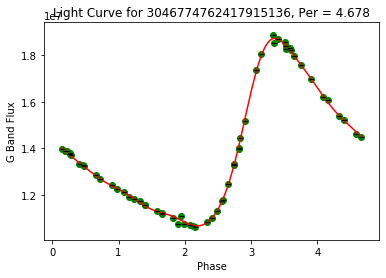

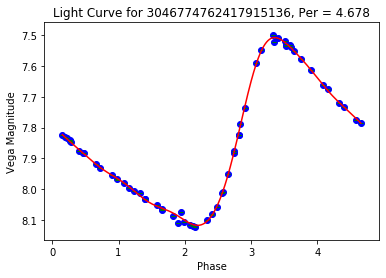

C_mag            = 7.845614222231223
C_flux           = 7.827715041484147
WF_mag           = 7.824590593592621
Mean_flux        = 7.830667057715594
Mean_mag         = 7.849281661719563
int_avg_mag      = 7.830550402788656
Gisella          = 7.828565857164136


In [11]:
sources = 'vari_cepheids_long.txt'
lcs = 'lcs_3044.txt'
LightCurver(sources, lcs)

In [12]:
lc_files = glob.glob('lcs_*.txt')
#for i in range(0, len(lc_files)):
    #LightCurver(sources, lc_files[i])

In [15]:
#job2 = Gaia.launch_job_async("select top 10000 * from gaiadr2.vari_time_series_statistics order by source_id")
#res = job2.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [29]:
#np.set_printoptions(threshold=np.inf)
#source_IDs = np.array(res['source_id'])
#num_selected = np.array(res['num_selected_g_fov'])
#print(np.sort(num_selected))

In [30]:
#len(num_selected)

In [31]:
#print(source_IDs)